In [1]:
from functions import sample_hyperparameters, get_features, discretize_trajectories, get_feature_traj_paths, bootstrap_ts2
import pickle
import numpy as np
import pyemma as pm
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from pathlib import Path

In [2]:
search_space = pickle.load(open('common/hp_search_space.p', 'rb'))
lags = (np.arange(10, 50)*10).astype(int)
features = ["contact_filtered", 'alpha', 'phi_psi']
sim_names = ['transition_state', 'reactant']

# Introduction

In this notebook we'll determine an appropriate lag time.
To do this, we'll bootstrap the slowest timescale and find where it converges. 
We'll do this for every transition state/reaction/feature combination with 5 random draws of the other hypeparameters. 
Convergence will be judged by the first change in T2 less than 100 ns over 1ns of lag time. The lag time will be the smallest lag time from among the sampled hyperparameters. 

First, we find an appropriate number of bootstrap samples. 

Then we do this for all other combinations of hyperparameters and simulation systems (reactant/transition state). 

In another workbook, we'll analyse the results. 

In [4]:
np.random.seed(93475)

traj_paths = get_feature_traj_paths(sim_names[-1], features[-1])
hps = sample_hyperparameters(search_space)
bs_its = bootstrap_ts2(n=300, hps=hps, traj_paths=traj_paths, lags=lags)

8


In [5]:
var_vs_size = []
for i in range(10, bs_its.shape[0]):
    var_vs_size.append(np.std(bs_its[:i, -1, 0]))


(3.0, 4.0)

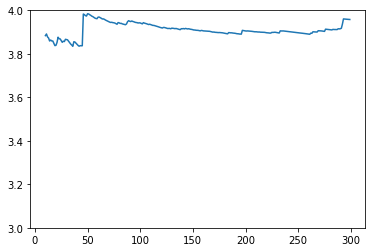

In [20]:
plt.plot(range(10, 300), np.log10(var_vs_size))
# plt.yscale('log')
plt.ylim(3,4)


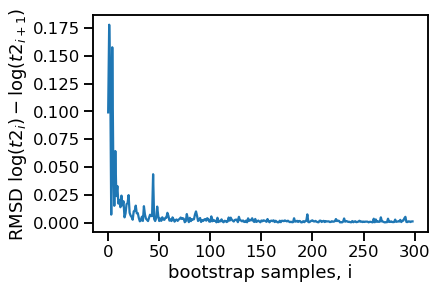

In [9]:
mean_bs_its = np.mean(bs_its, axis=0)

cum_mean_its = np.cumsum(bs_its, axis=0)/(np.arange(bs_its.shape[0])[:, None, None]+1)

diffs = np.sqrt(np.mean((np.log10(cum_mean_its[:-1, :, 0]) - np.log10(cum_mean_its[1:, :, 0]))**2, axis=1))

with sns.plotting_context('talk', font_scale=1):
    plt.plot(diffs)
#     plt.yscale('log')
    plt.xlabel('bootstrap samples, i')
    plt.ylabel('RMSD $\log(t2_{i}) - \log(t2_{i+1})$')

100 bootstrap samples seems fine. 

In [10]:
np.random.seed(93475)

hps_per_feature = 5
n_bootstraps = 100

for sim in sim_names:
    for feature in features:
        
        traj_paths = get_feature_traj_paths(sim, feature)
#         trajs = get_features(traj_paths)

        for i in range(hps_per_feature):
            hps = sample_hyperparameters(search_space)
            fname = f"{sim}_{feature}_l{hps['vamp']['lag']}_d{hps['vamp']['dim']}_n{hps['cluster_kmeans']['k']}.p"
            fpath = join('lag_determination', fname)
            if not Path(fpath).exists():
                print(fname)

                try:
                    bs_its = bootstrap_ts2(n=n_bootstraps, hps=hps, traj_paths=traj_paths, lags=lags)
                    pickle.dump(file=open(fpath, 'wb'), obj=[hps, bs_its])
                except: 
                    print('ERROR with ', fname)

transition_state_contact_filtered_l16_d4_n187.p
8
transition_state_contact_filtered_l189_d5_n32.p
8
transition_state_contact_filtered_l17_d4_n118.p
8
transition_state_contact_filtered_l103_d6_n40.p
8
transition_state_contact_filtered_l75_d7_n67.p
8
transition_state_alpha_l65_d5_n151.p
8
transition_state_alpha_l114_d3_n47.p
8
transition_state_alpha_l210_d3_n81.p
8
transition_state_alpha_l200_d3_n57.p
8
transition_state_alpha_l197_d7_n39.p
8
transition_state_phi_psi_l76_d6_n32.p
8
transition_state_phi_psi_l239_d2_n75.p
8
transition_state_phi_psi_l168_d2_n144.p
8
transition_state_phi_psi_l124_d10_n201.p
8
transition_state_phi_psi_l80_d5_n34.p
8
reactant_contact_filtered_l63_d9_n129.p
8
reactant_contact_filtered_l116_d5_n89.p
8
reactant_contact_filtered_l98_d6_n83.p
8
reactant_contact_filtered_l223_d5_n151.p
8
reactant_contact_filtered_l106_d3_n149.p
8
reactant_alpha_l191_d5_n174.p
8
reactant_alpha_l96_d3_n66.p
8
reactant_alpha_l155_d4_n116.p
8
reactant_alpha_l215_d5_n60.p
8
reactant_alpha

In [16]:
# hps_per_feature = 5
n_bootstraps = 100
sim = 'reactant'
feature = 'phi_psi'
hps = sample_hyperparameters(search_space)
print(hps)
fname = f"{sim}_{feature}_l{hps['vamp']['lag']}_d{hps['vamp']['dim']}_n{hps['cluster_kmeans']['k']}.p"
fpath = join('lag_determination', fname)
traj_paths = get_feature_traj_paths(sim, feature)

bs_its = bootstrap_ts2(n=n_bootstraps, hps=hps, traj_paths=traj_paths, lags=lags)


pickle.dump(file=open(fpath, 'wb'), obj=[hps, bs_its])


{'vamp': {'dim': 5, 'lag': 144}, 'cluster_kmeans': {'k': 103, 'max_iter': 1000}}
8
